In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1' # For M1 architectures

import fastai
from fastai.vision.all import *
from pathlib import Path
import numpy as np

In [2]:
fastai.__version__

'2.7.18'

In [4]:
classes = np.array([ 'Background', 'Micronucleus' ], dtype='<U17')

In [5]:
src_size = np.array([ 96, 96 ])
bs = 32 # On CPU, so lets keep the batch size small

In [35]:
# FastAI2 dataloader wants all the images in one folder, and will randomly split by validation percent
annotations_path = Path('./training-data/rpe-1/all')

valid_pct = 0.12

def label_func(x):
    return x.parent.parent / 'annotations/{}.png'.format(x.stem)
    
data = SegmentationDataLoaders.from_label_func(
    annotations_path,
    fnames=[ x for x in annotations_path.iterdir() if x.name[0] != "." ], # Skip hidden files
    label_func=label_func,
    valid_pct=valid_pct,
    codes={ classes[0]: 0, classes[1]: 1 },
    bs=bs,
    batch_tfms=[*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

In [36]:
wd=1e-3
learn18 = unet_learner(data, models.resnet18, wd=wd, loss_func=FocalLossFlat(axis=1))

SuggestedLRs(valley=0.00015848931798245758)

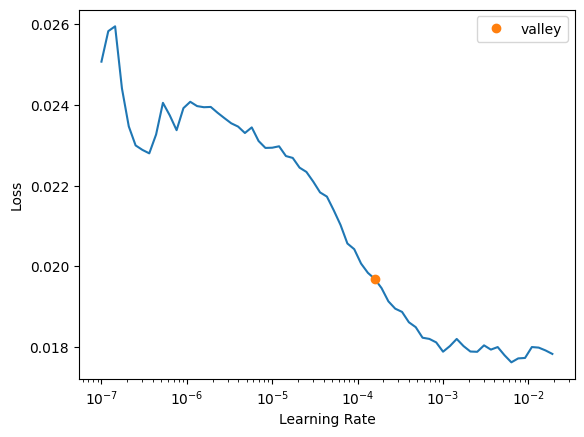

In [23]:
learn18.lr_find()

In [37]:
lr=1.5e-4
learn18.fit_one_cycle(30, lr, pct_start=0.9)

epoch,train_loss,valid_loss,time
0,0.037031,0.026779,00:10
1,0.025624,0.020351,00:10
2,0.020206,0.017283,00:11
3,0.016912,0.014906,00:10
4,0.014432,0.011947,00:10
5,0.011911,0.009919,00:10
6,0.009735,0.009130,00:11
7,0.008481,0.008390,00:10
8,0.007607,0.009229,00:10
9,0.007000,0.007739,00:10


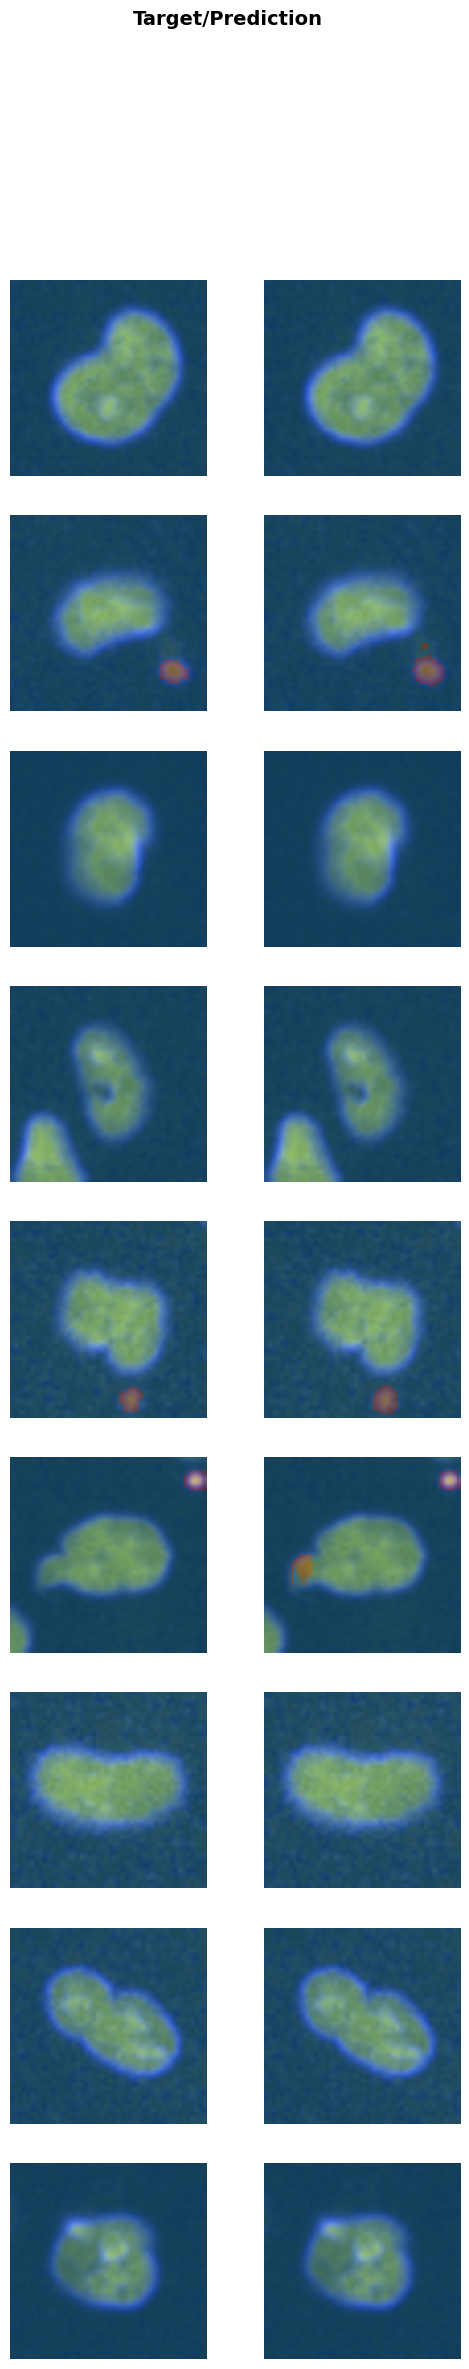

In [38]:
learn18.show_results()

In [44]:
Path('./models').mkdir(exist_ok=True)

In [ ]:
from datetime import datetime
today = datetime.today().strftime("%Y-%m-%d")
learn18.save(Path(f'./models/{today}-stage-1-unet-micronucleus18').resolve())

In [48]:
learn18.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

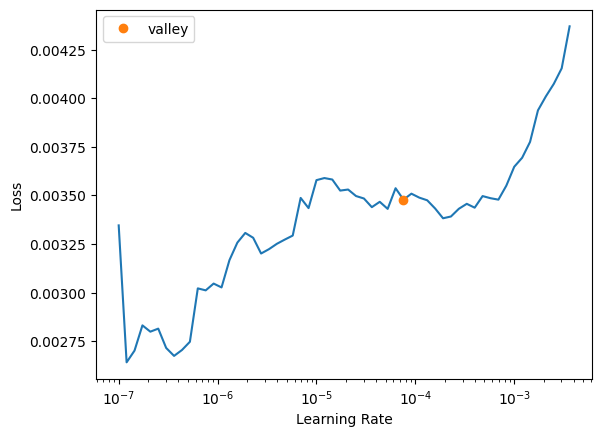

In [49]:
learn18.lr_find()

In [51]:
lrs = slice(1e-5,1e-6)
learn18.fit_one_cycle(10,lrs,wd=1e-3)

epoch,train_loss,valid_loss,time
0,0.003294,0.006283,00:10
1,0.003401,0.006319,00:11
2,0.003359,0.006429,00:11
3,0.003313,0.006483,00:11
4,0.003430,0.006382,00:11
5,0.003443,0.006454,00:11
6,0.003323,0.006488,00:11
7,0.003382,0.006474,00:11
8,0.003384,0.006425,00:11
9,0.003358,0.006414,00:11


In [ ]:
learn18.save(Path(f'./models/{today}-stage-2-unet-micronucleus18').resolve())

In [55]:
export_root = Path('./models-exported')
export_root.mkdir(exist_ok=True)
export_path = (export_root / f"{today}").resolve()
export_path.mkdir(exist_ok=True)

learn18.export(str(export_path / 'export.pkl'))

In [28]:
from tqdm.notebook import tqdm, trange
from PIL import Image
import pandas as pd
from skimage.measure import label, regionprops_table
from skimage.filters import sobel
from tifffile import tifffile
import skimage

def normalize_image(img):
    percentile = 99.9
    high = np.percentile(img, percentile)
    low = np.percentile(img, 100-percentile)

    img = np.minimum(high, img)
    img = np.maximum(low, img)

    img = (img - low) / (high - low) # gives float64, recast as 8-bit
    img = skimage.img_as_ubyte(img)

    return img
    
# Compare to existing predictions
def make_crops(path, crop_size=48):
    image_ids = [ x.stem for x in (path / "mn_details").iterdir() if x.suffix == ".png" and x.name[0] != "." ]
    crops = []
    for image_id in tqdm(image_ids):
        h2b = tifffile.imread(path / "mn_details/images/{}_w1.TIF".format(image_id))
        h2b = normalize_image(h2b)
        
        pn_info = np.array(Image.open(path / "mn_details/pns/{}.png".format(image_id)))
        mn_info = np.array(Image.open(path / "mn_details/{}.png".format(image_id)))
        pred_info = np.array(Image.open(path / "mn_predictions/{}.png".format(image_id)))

        pred_details = np.zeros(( pn_info.shape[0], pn_info.shape[1] ), dtype=np.uint8)
        pred_details[pred_info[...,0] != 0] = 1
        
        pn_details = np.zeros(( pn_info.shape[0], pn_info.shape[1] ), dtype=np.uint16)
        pn_details[pn_info[...,0] == 100] = 1 # MN-
        pn_details[pn_info[...,0] == 255] = 2 # MN+
        pn_details = label(pn_details, connectivity=1)
        
        centroids = pd.DataFrame(regionprops_table(pn_details, properties=('label', 'centroid'))).rename(columns={"centroid-0":"y", "centroid-1":"x"})
        centroids['x'] = centroids['x'].astype(int)
        centroids['y'] = centroids['y'].astype(int)

        for row in centroids.itertuples():
            crop = np.zeros(( crop_size, crop_size, 3 ), dtype=h2b.dtype)
            mask = np.zeros(( crop_size, crop_size ), dtype=np.uint8)
            pred = np.zeros(( crop_size, crop_size ), dtype=np.uint8)
            
            left = row.x-(crop_size//2)
            right = row.x+(crop_size//2)
            top = row.y-(crop_size//2)
            bottom = row.y+(crop_size//2)

            if top < 0:
                top = 0
            if bottom > h2b.shape[0]:
                bottom = h2b.shape[0]
            if left < 0:
                left = 0
            if right > h2b.shape[1]:
                right = h2b.shape[1]

            crop_height = bottom-top
            crop_width = right-left
            norm_h2b_crop = normalize_image(h2b[top:bottom, left:right])
            crop[0:crop_height, 0:crop_width, 0] = norm_h2b_crop
            crop[0:crop_height, 0:crop_width, 1] = norm_h2b_crop
            crop[0:crop_height, 0:crop_width, 2] = normalize_image(sobel(norm_h2b_crop))

            pred[0:crop_height, 0:crop_width] = pred_details[top:bottom, left:right]

            pn_mask = pn_details.copy()
            pn_mask[pn_mask != row.label] = 0
            pn_mask[pn_mask != 0] = 1
            mask[0:crop_height, 0:crop_width] = pn_mask[top:bottom, left:right]

            # Need to add MN mask as well
            # Get the original PN ID in the annotated masks
            mn_mask = np.zeros_like(pn_mask, dtype=np.uint8)
            mn_mask[mn_info[...,0] != 0] = 2
            mask[0:crop_height, 0:crop_width] += mn_mask[top:bottom, left:right]
            mask[mask > 2] = 2

            crops.append({ 'image': crop.copy(), 'image_id': image_id, 'coords': (top, right, bottom, left), 'mask': mask.copy(), "pred": pred.copy() })
    return crops
crops = make_crops(Path("/Volumes/T7/Experimental data/Fowler MN/2022-03-18 Emi RNAseq/200-800"))

  0%|          | 0/3 [00:00<?, ?it/s]

4 (14, 766, 62, 718) [0 1 2]


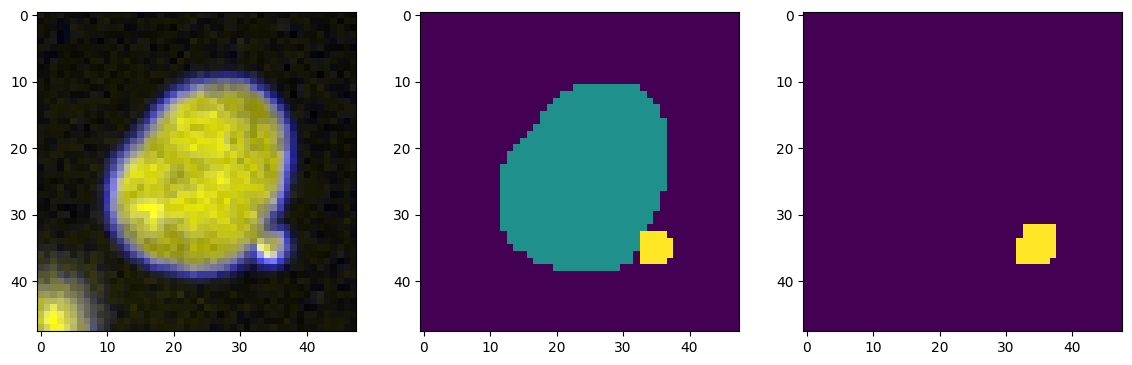

In [29]:
f,ax = plt.subplots(1,3,figsize=(14,10))

ax[0].imshow(crops[5]['image'])
ax[1].imshow(crops[5]['mask'])
ax[2].imshow(crops[5]['pred'])
print(crops[5]['image_id'], crops[5]['coords'], np.unique(crops[5]['mask']))

In [1]:
bs

NameError: name 'crops' is not defined

In [30]:
from skimage.exposure import rescale_intensity
import torchvision.transforms.v2 as transforms

normalize = transforms.Normalize(*imagenet_stats)

orig_iou = []
new_iou = []

for idx,c in enumerate(crops):
    out = np.argmax(learn18.predict(normalize(c['image']))[2], axis=0).numpy()
    intersection = np.sum(np.logical_and(out == 1, c['mask'] == 2))
    union = np.sum(np.logical_or(out == 1, c['mask'] == 2))
    if union > 0:
        new_iou.append(intersection/union)
    else:
        new_iou.append(0)

    intersection = np.sum(np.logical_and(c['pred'] == 1, c['mask'] == 2))
    union = np.sum(np.logical_or(c['pred'] == 1, c['mask'] == 2))
    if union > 0:
        orig_iou.append(intersection/union)
    else:
        orig_iou.append(0)
    crops[idx]['new_pred'] = out

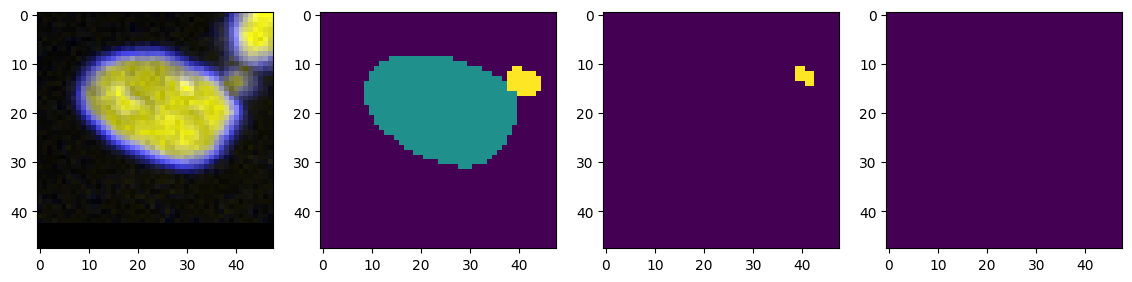

In [33]:
f,ax = plt.subplots(1,4,figsize=(14,10))

idx = 1
ax[0].imshow(crops[idx]['image'])
ax[1].imshow(crops[idx]['mask'])
ax[2].imshow(crops[idx]['pred'])
ax[3].imshow(crops[idx]['new_pred'])


In [34]:
print(np.mean(orig_iou), np.mean(new_iou))

0.20026919164196105 0.06573771840123309
